## **Spatial Temporal Diffusion Environment API**

In [5]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

### Spatial Temporal Diffusion Field & Environment Class

#### 1. Spatial-Temporal Diffusion Field

In [6]:
DEFAULT_FIELD_PARAMS = [0, 0, 1.0]     # Vx, Vy, K
DEFAULT_ENV_PARAMS = [0.8, 0.8, 0.1]  # dx, dy, dt

# ---------------------------------------------------------------
# SPATIAL-TEMPORAL DIFFUSION FIELD
# ---------------------------------------------------------------
class SpatialTemporalDiffusionField():
    def __init__(self, pos=(50,50), map_size=100, field_size=40, field_max=25, n_timesteps=None, field_params=DEFAULT_FIELD_PARAMS, env_params=DEFAULT_ENV_PARAMS):
        # initialize field params
        self.dx, self.dy, self.dt = env_params
        self.vx, self.vy, self.k = field_params
        self.field_size, self.field_max, self.map_size = field_size, field_max, map_size
        self.snapshots = None
        # generate field
        field_hsize = field_size // 2
        self.gaussian_field = self.generate_multivariate_gaussian_field(N=field_size)
        self.field = np.zeros((map_size, map_size))
        self.padded_field = np.zeros((3*map_size, 3*map_size))
        x_start, x_end = map_size+pos[0]-field_hsize, map_size+pos[0]+field_hsize
        y_start, y_end = map_size+pos[1]-field_hsize, map_size+pos[1]+field_hsize
        self.padded_field[y_start:y_end, x_start:x_end]=self.gaussian_field
        self.field = self.padded_field[map_size:map_size*2,map_size:map_size*2]
        self.field = (self.field - np.min(self.field)) / (np.max(self.field)-np.min(self.field)) * self.field_max
        # generate snapshots
        if (n_timesteps is not None) and (n_timesteps > 0):
            self.snapshots = np.zeros((n_timesteps,map_size,map_size))
            self.snapshots[0] = self.field
            for i in range(1, n_timesteps):
                self.snapshots[i] = self.update_diffusion_field(self.snapshots[i-1])        
    
    def generate_multivariate_gaussian_field(self, N=40, mu=np.array([0.,0.]), sigma=np.array([[1.,0.],[0.,1.]])):
        X = np.linspace(-3, 3, N)
        Y = np.linspace(-3, 3, N)
        X, Y = np.meshgrid(X, Y)
        pos = np.empty(X.shape + (2,))
        pos[:,:,0] = X
        pos[:,:,1] = Y
        n = mu.shape[0]
        sigma_det, sigma_inv = np.linalg.det(sigma), np.linalg.inv(sigma)
        N = np.sqrt((2*np.pi)**n * sigma_det)
        fac = np.einsum('...k,kl,...l->...', pos-mu, sigma_inv, pos-mu)
        return np.exp(-fac / 2) / N
    
    def update_diffusion_field(self, field):
        updated_u = field.copy()
        u_k = field.copy()
        for i in range(1, field.shape[0] - 1):
            for j in range(1, field.shape[1] - 1):
                updated_u[j, i] = u_k[j, i] + self.k * (self.dt / self.dx ** 2) * \
                    ((u_k[j + 1, i] + u_k[j - 1, i] +
                      u_k[j, i + 1] + u_k[j, i - 1] - 4 * u_k[j, i])) + \
                    self.vx * (self.dt / self.dx) * ((u_k[j + 1, i] - u_k[j, i])) + self.vy * (self.dt / self.dy) * \
                    (u_k[j, i + 1] - u_k[j, i])
        return updated_u

#### 2. Spatial-temporal Diffusion Field Environment
Wrapper class for handling multiple diffusion fields within a global map

In [9]:
# ---------------------------------------------------------------
# SPATIAL-TEMPORAL DIFFUSION ENVIRONMENT
# (consists of multiple diffusion fields)
# ---------------------------------------------------------------
class SpatialTemporalDiffusionEnvironment():
    def __init__(self, name, configs=[], env_params=DEFAULT_ENV_PARAMS, size=100, use_snapshots=True, n_timesteps=300):
        self.name = name
        self.field_size = size
        self.configs = configs
        self.dx, self.dy, self.dt = env_params
        self.n_timesteps = n_timesteps
        self.fields=[]
        self.timestep = 0
        for idx, config in enumerate(configs):
            self.fields.append(SpatialTemporalDiffusionField(pos=config['pos'], field_size=config['size'], field_params=config['params'], \
                    env_params=env_params, map_size=size, n_timesteps=n_timesteps if use_snapshots else None))
        self.set_timestep()
    
    def set_timestep(self, t=0):
        self.isolated_field_states = np.array([self.fields[i].snapshots[t] for i in range(len(self.fields))])
        self.env_field = np.sum(self.isolated_field_states, axis=0)
        self.timestep = t
        
    def step(self):
        if self.timestep < self.n_timesteps:
            self.set_timestep(self.timestep + 1)
        
    def get_single_field(self, idx=0):
        if (idx>=0) and (idx<len(self.fields)):
            return self.isolated_field_states[idx]
        else:
            return None
        
    def compute_gradient(self, pos=[50,50]):
        dz_dx = (self.env_field[pos[1], pos[0]+1] -
                 self.env_field[pos[1], pos[0]-1]) / (2 * self.dx)
        dz_dy = (self.env_field[pos[1]+1, pos[0]] -
                 self.env_field[pos[1]-1, pos[0]]) / (2 * self.dy)
        return np.array([dz_dx, dz_dy])
    
    def get_concentration(self, pos=[50,50]):
        return self.env_field[pos[1],pos[0]]

### Generating diffusion field environments
#### 1. Generating Static Environments

Generated env '1-src-1' (./data/envs/1-src-1.dat)
Generated env '1-src-2' (./data/envs/1-src-2.dat)
Generated env '1-src-3' (./data/envs/1-src-3.dat)
Generated env '2-src-1' (./data/envs/2-src-1.dat)
Generated env '2-src-2' (./data/envs/2-src-2.dat)
Generated env '2-src-3' (./data/envs/2-src-3.dat)
Generated env '2-src-4' (./data/envs/2-src-4.dat)
Generated env '2-src-5' (./data/envs/2-src-5.dat)
Generated env '3-src-1' (./data/envs/3-src-1.dat)
Generated env '3-src-2' (./data/envs/3-src-2.dat)
Generated env '3-src-3' (./data/envs/3-src-3.dat)
Generated env '3-src-4' (./data/envs/3-src-4.dat)
Generated env '3-src-5' (./data/envs/3-src-5.dat)
Generated env '4-src-1' (./data/envs/4-src-1.dat)
Generated env '4-src-2' (./data/envs/4-src-2.dat)


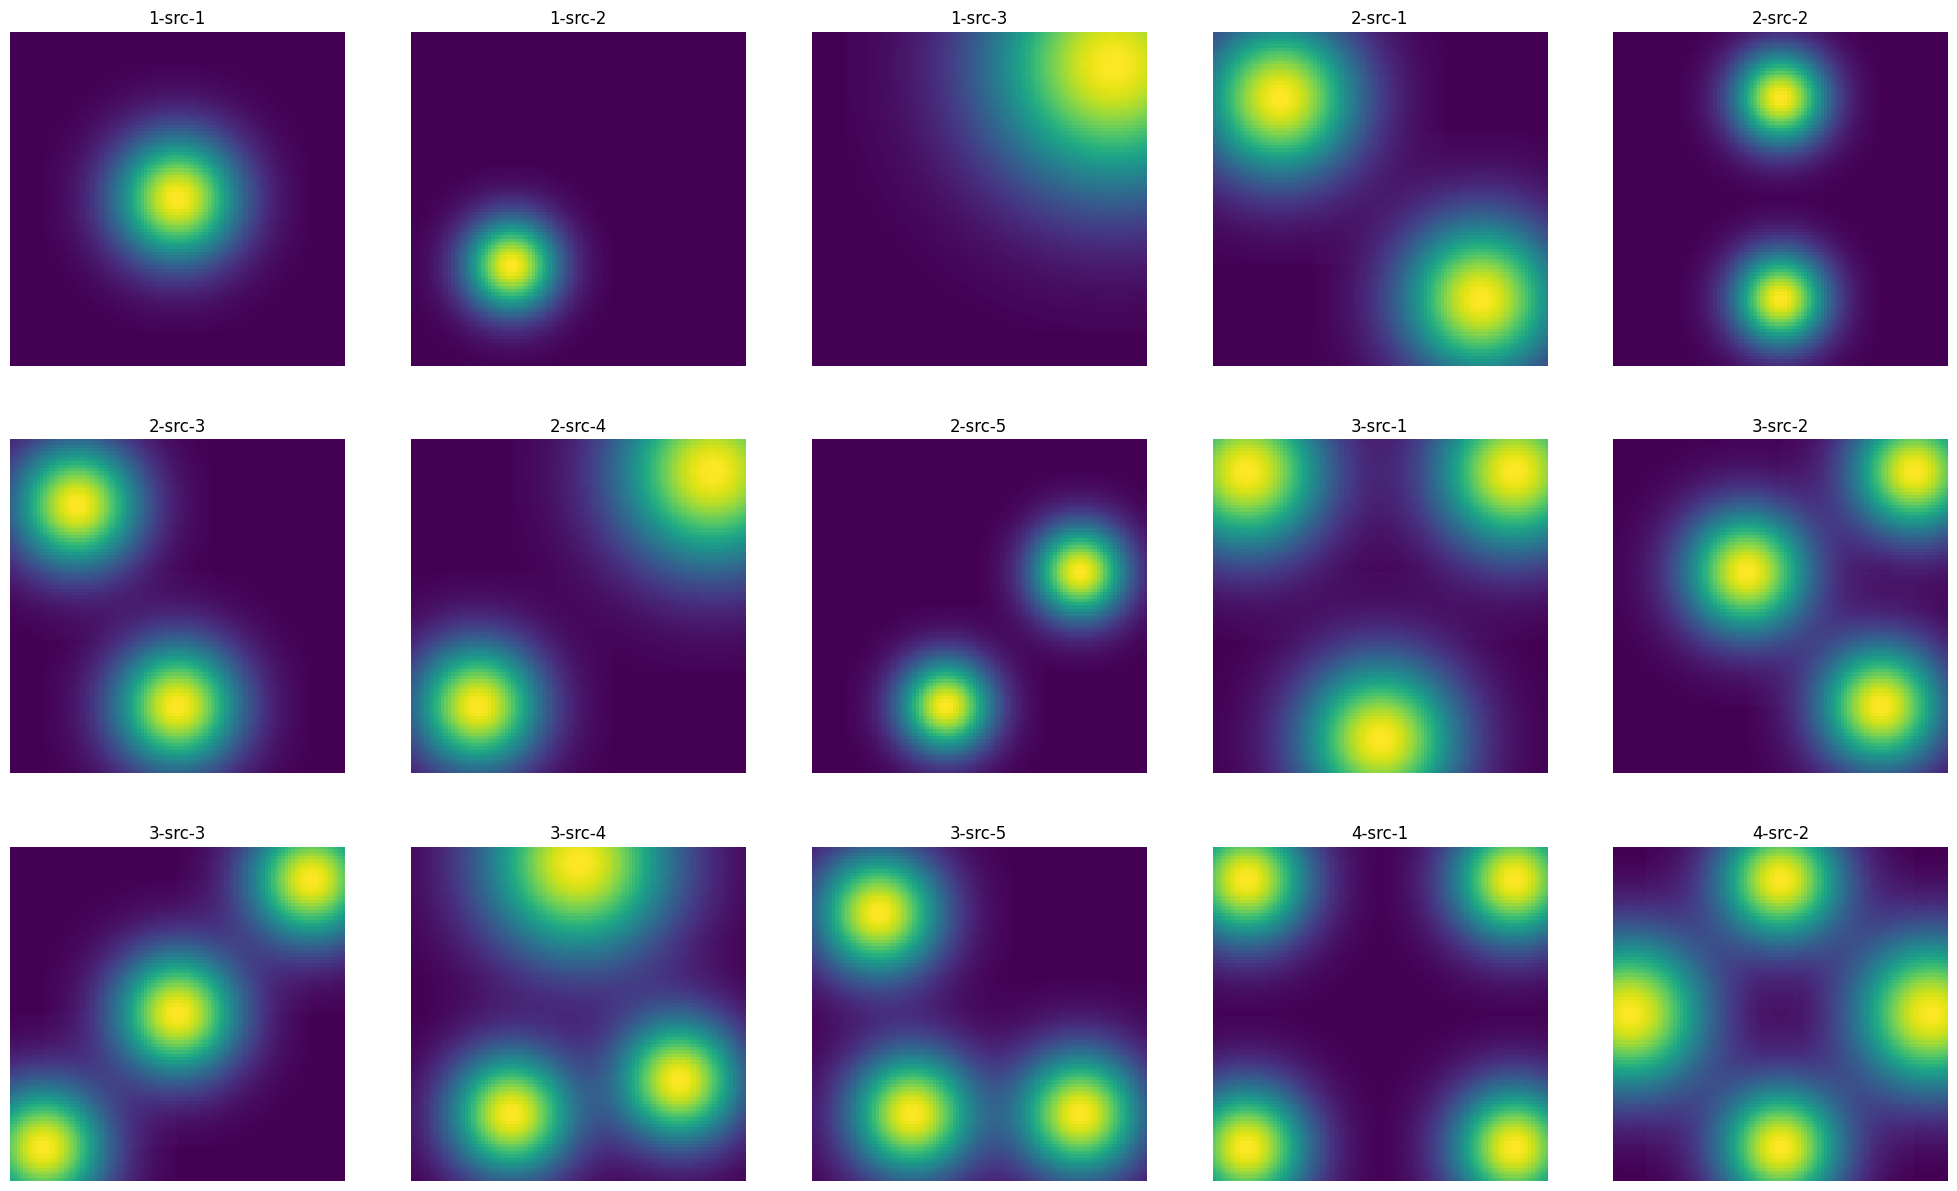

In [11]:
from collections import OrderedDict

# Configurations of all environments (from 1-src to 4-src), params --> vx,vy,k
configs = OrderedDict([
    ('1-src-1',[{'pos': (50,50), 'size': 80,  'params': [0.0, 0.0, 1]}]),
    ('1-src-2',[{'pos': (30,70), 'size': 60,  'params': [0.0, 0.0, 1]}]),
    ('1-src-3',[{'pos': (90,10), 'size': 160, 'params': [0.0, 0.0, 1]}]),
    ('2-src-1',[{'pos': (20,20), 'size': 100, 'params': [0.0, 0.0, 1]},
                {'pos': (80,80), 'size': 100, 'params': [0.0, 0.0, 1]},]),
    ('2-src-2',[{'pos': (50,20), 'size': 60,  'params': [0.0, 0.0, 1]},
                {'pos': (50,80), 'size': 60,  'params': [0.0, 0.0, 1]},]),
    ('2-src-3',[{'pos': (20,20), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (50,80), 'size': 80,  'params': [0.0, 0.0, 1]},]),
    ('2-src-4',[{'pos': (20,80), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (90,10), 'size': 120, 'params': [0.0, 0.0, 1]},]),
    ('2-src-5',[{'pos': (40,80), 'size': 60,  'params': [0.0, 0.0, 1]},
                {'pos': (80,40), 'size': 60,  'params': [0.0, 0.0, 1]},]),
    ('3-src-1',[{'pos': (10,10), 'size': 100, 'params': [0.0, 0.0, 1]},
                {'pos': (50,90), 'size': 100, 'params': [0.0, 0.0, 1]},
                {'pos': (90,10), 'size': 100, 'params': [0.0, 0.0, 1]},]),
    ('3-src-2',[{'pos': (40,40), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (80,80), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (90,10), 'size': 80,  'params': [0.0, 0.0, 1]},]),
    ('3-src-3',[{'pos': (50,50), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (10,90), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (90,10), 'size': 80,  'params': [0.0, 0.0, 1]},]),
    ('3-src-4',[{'pos': (50,5),  'size': 120, 'params': [0.0, 0.0, 1]},
                {'pos': (30,80), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (80,70), 'size': 80,  'params': [0.0, 0.0, 1]},]),
    ('3-src-5',[{'pos': (20,20), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (80,80), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (30,80), 'size': 80,  'params': [0.0, 0.0, 1]},]),
    ('4-src-1',[{'pos': (10,10), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (90,10), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (90,90), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (10,90), 'size': 80,  'params': [0.0, 0.0, 1]}]),
    ('4-src-2',[{'pos': (50,10), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (50,90), 'size': 80,  'params': [0.0, 0.0, 1]},
                {'pos': (5,50),  'size': 100, 'params': [0.0, 0.0, 1]},
                {'pos': (95,50), 'size': 100, 'params': [0.0, 0.0, 1]}]),
])

# Initialize all environments
# This will take some time ...
fig, axes = plt.subplots(len(configs)//5, 5, figsize=(25, 15))

for idx, name in enumerate(configs.keys()):
    env = SpatialTemporalDiffusionEnvironment(name, configs=configs[name])
    with open(f'./data/envs/{name}.dat', 'wb') as handle:
        pickle.dump(env, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Generated env '{name}' (./data/envs/{name}.dat)")
    axes[idx//5,idx%5].imshow(env.env_field)
    axes[idx//5,idx%5].set_title(name)
    axes[idx//5,idx%5].axis("off")
plt.show()

#### 2. Loading and testing an environment

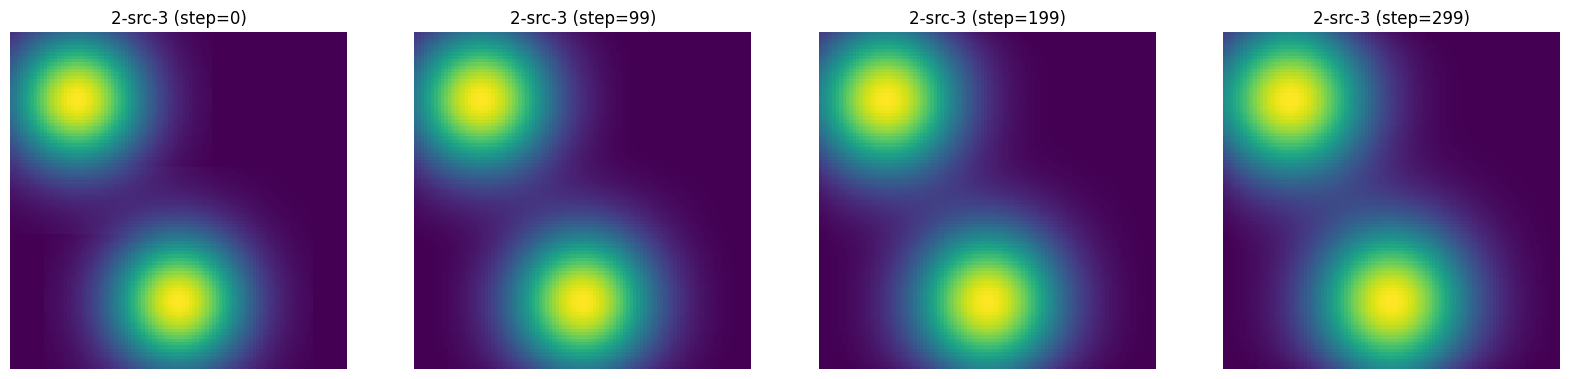

In [71]:
ENV_NAME = '2-src-3'

with open(f'./data/envs/{ENV_NAME}.dat', 'rb') as handle:
    env = pickle.load(handle)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for idx, step in enumerate([0,99,199,299]):
    env.set_timestep(step)
    axes[idx].imshow(env.env_field)
    axes[idx].set_title(f"{ENV_NAME} (step={step})")
    axes[idx].axis("off")
plt.show()

#### 3. Inspect Isolated Fields

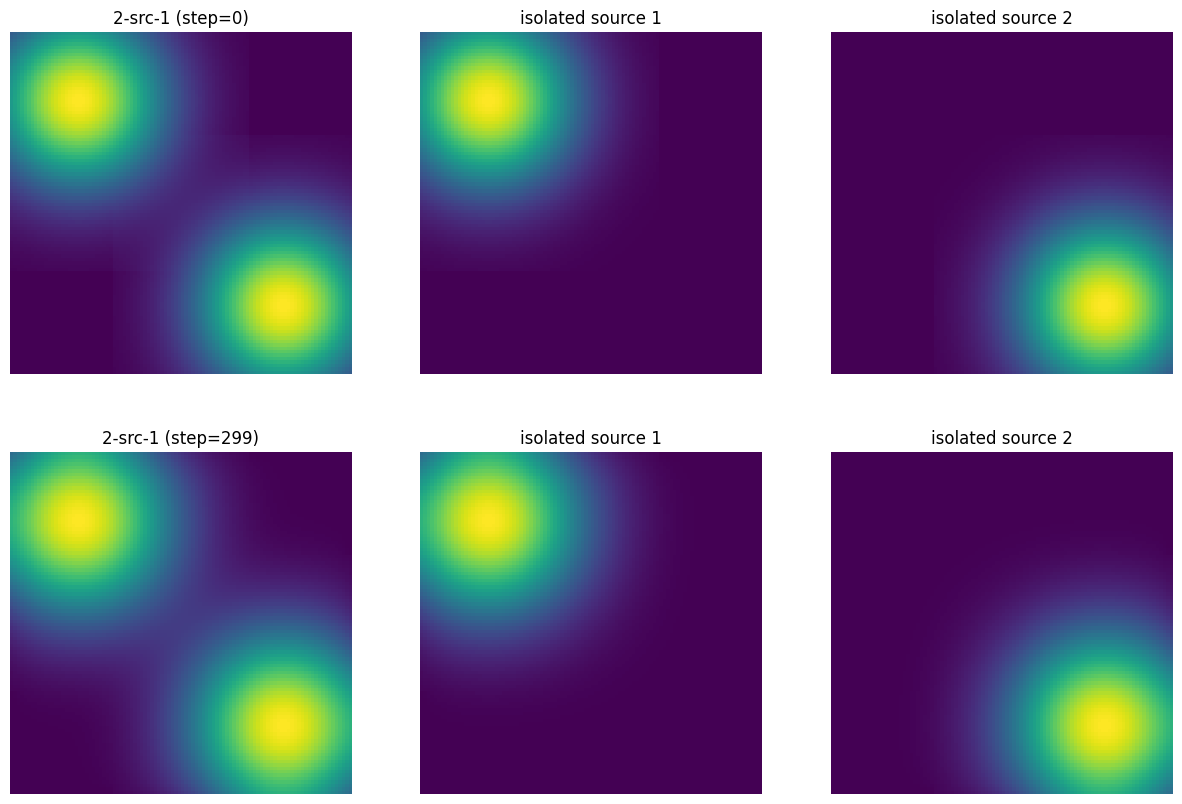

In [72]:
ENV_NAME = '2-src-1'

with open(f'./data/envs/{ENV_NAME}.dat', 'rb') as handle:
    env = pickle.load(handle)

fig, axes = plt.subplots(2, 1+len(env.fields), figsize=(15, 10))
for idx, step in enumerate([0,299]):
    env.set_timestep(step)
    axes[idx, 0].imshow(env.env_field)
    axes[idx, 0].set_title(f"{ENV_NAME} (step={step})")
    axes[idx, 0].axis("off")
    for field_id in range(len(env.fields)):
        axes[idx, 1+field_id].imshow(env.isolated_field_states[field_id])
        axes[idx, 1+field_id].set_title(f"isolated source {field_id+1}")
        axes[idx, 1+field_id].axis("off")
plt.show()